<a href="https://colab.research.google.com/github/paviayyala/AIML-Lab/blob/main/Building_AI_Agents_with_LangChain.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Problem Statement

## Business Context

In today's fast-paced business environment, organizations rely heavily on efficient meeting coordination to drive collaboration, decision-making, and project execution. With the rise of remote and hybrid work models, teams are increasingly distributed across different time zones, locations, and schedules. Modern businesses require seamless coordination tools that can handle complex scheduling requirements while minimizing administrative overhead. Meeting coordination has become a critical operational function that directly impacts productivity, employee satisfaction, and business outcomes.

## Problem Definition

Organizations face significant challenges in coordinating meetings across multiple stakeholders with complex schedules. Traditional meeting scheduling involves extensive back-and-forth communication via email or phone calls, leading to scheduling conflicts, double bookings, and wasted productivity. Office managers and administrative assistants spend countless hours manually checking calendars, finding available time slots, and coordinating conference room reservations. This inefficient process often results in delayed project timelines, missed collaboration opportunities, and frustrated team members who struggle to find common meeting times. Additionally, the lack of real-time visibility into room availability and attendee schedules creates further complications, potentially causing meetings to be scheduled in occupied rooms or at times when key participants are unavailable.

# Objective

To address these operational challenges, we propose implementing an **AI-powered Meeting Scheduler Agent**
that automates the entire meeting coordination process. This intelligent system will enable users to schedule
meetings using natural language requests, automatically check calendar availability across multiple attendees,
and seamlessly book conference rooms. By leveraging advanced AI capabilities, the system aims to eliminate
manual scheduling overhead, reduce coordination time from hours to minutes, and ensure optimal resource
utilization.

The Meeting Scheduler Agent will transform how organizations handle meeting coordination by providing:
- Instant availability checking across multiple calendars
- Automated conflict detection and resolution
- Smart conference room booking based on meeting requirements  
- Natural language processing for intuitive user interactions
- Real-time meeting management and tracking

By streamlining the scheduling process, organizations can expect increased productivity, improved collaboration
efficiency, and enhanced employee satisfaction through reduced administrative burden.

# Importing the necessary libraries and the model

### About **Langchain**

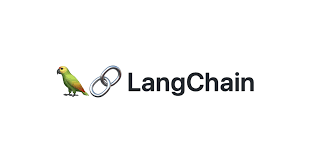

LangChain is an open-source framework that simplifies the development of applications powered by large language models (LLMs). It provides tools and abstractions to connect LLMs with external data, memory, and tools, enabling the creation of more dynamic and context-aware applications.

### How to use google secrets

Click on the icon shown:-

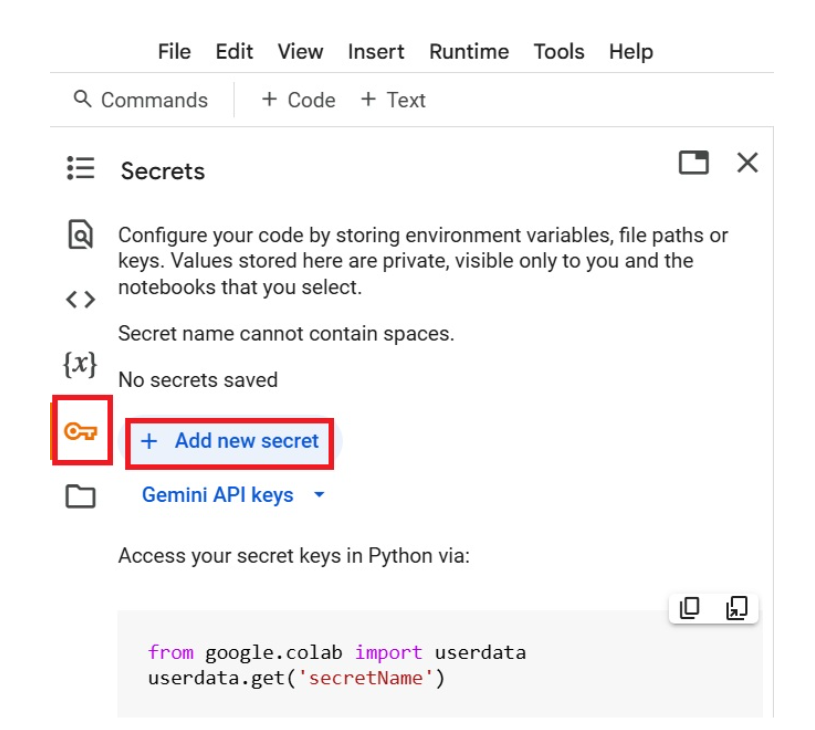

In the Name field, enter GROQ_API_KEY. In the Value field, paste your GROQ API Key and also dont forget to toggle it so that we can access the key in this notebook.
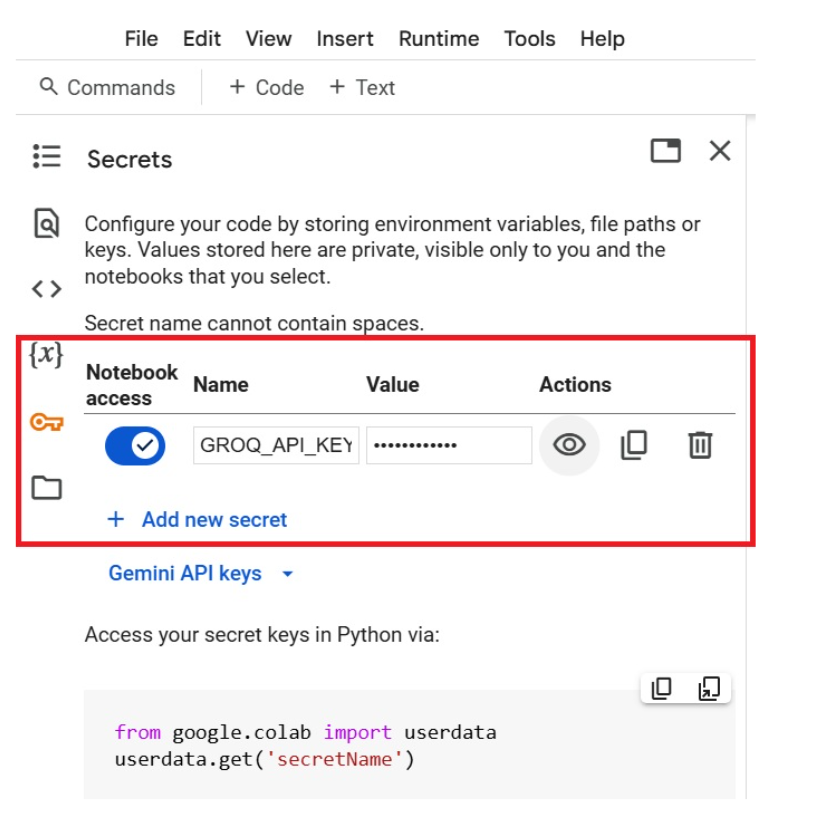

In [ ]:
!pip install langchain-community langchain-openai

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.4/74.4 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.2/45.2 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 3.6 MB/s eta 0:00:00


In [ ]:
!pip install -q google-ai-generativelanguage

In [ ]:
!pip install -q langchain-google-genai

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.4/49.4 kB 939.8 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 9.1 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-generativeai 0.8.5 requires google-ai-generativelanguage==0.6.15, but you have google-ai-generativelanguage 0.6.18 which is incompatible.


In [ ]:
import os
from datetime import datetime, timedelta
from typing import Dict, List, Optional
from langchain.agents import initialize_agent, AgentType
from langchain.tools import StructuredTool
from langchain.llms import OpenAI
from pydantic import BaseModel, Field
import json
from google.colab import userdata
from langchain.chat_models import ChatOpenAI

In [ ]:
from langchain_google_genai import ChatGoogleGenerativeAI

llm = ChatGoogleGenerativeAI(
    model="gemini-1.5-flash",   # or gemini-1.5-pro for better quality
    google_api_key=userdata.get('GOOGLE_API_KEY'),
    temperature=0
)

# Example usage
response = llm.invoke("Explain AWS EFS in simple terms.")
print(response.content)


Imagine you have a bunch of computers working together on a big project.  They all need to access the same files, like a shared drive.  AWS EFS is like that shared drive, but in the cloud.

It's a **fully managed** network file system, meaning AWS handles all the hard work of keeping it running and secure.  You just connect your computers (EC2 instances, for example) to it, and they can all read and write files to the same place.

**Key features in simple terms:**

* **Shared storage:** Multiple computers can access the same files simultaneously.
* **Scalable:**  It automatically grows as you need more storage.
* **Durable:** Your data is protected against failures.
* **Easy to use:**  AWS handles the complex stuff, you just connect and use it.

Think of it as a super-powered, cloud-based network drive that's always available and scales automatically.  It's great for applications that need shared access to files, like web servers, databases, and media processing.


This code sets up a connection to gpt-4o model provided by OpenAI. It uses specific settings to ensure consistent answers and can retry sending a request up to five times if there are issues. The API key and URL needed to connect are fetched from a user data storage.

In [ ]:
# If you want to use OPEN AI KEY, uncomment below
# llm = ChatOpenAI(
#     model="gpt-4o",
#     temperature=0,
#     max_tokens=None,
#     timeout=None,
#     max_retries=5,
#     api_key=userdata.get('OPEN_AI_KEY'),
#     base_url=userdata.get('OPENAI_API_BASE')
#     )

# Creating utility functions

## Creating calendar related functions

This cell snippet initializes a dictionary called `CALENDAR_DB`, which acts as a mock database for storing calendar events for various attendees identified by their email addresses. Each entry maps an email address to a list of events, where each event is represented as a dictionary containing the event's start time, end time, and title. This structured information helps the `check_calendar_availability` function reference the schedules of attendees when checking for meeting availability.

In [ ]:
CALENDAR_DB = {
    "john@company.com": [
        {"start": "2025-07-23 09:00", "end": "2025-07-23 10:00", "title": "Team Standup"},
        {"start": "2025-07-23 14:00", "end": "2025-07-23 15:30", "title": "Client Call"},
        {"start": "2025-07-24 11:00", "end": "2025-07-24 12:00", "title": "Project Review"},
    ],
    "sarah@company.com": [
        {"start": "2025-07-23 10:00", "end": "2025-07-23 11:00", "title": "Design Review"},
        {"start": "2025-07-23 15:00", "end": "2025-07-23 16:00", "title": "1:1 Meeting"},
        {"start": "2025-07-24 09:30", "end": "2025-07-24 10:30", "title": "Planning Session"},
    ],
    "mike@company.com": [
        {"start": "2025-07-23 13:00", "end": "2025-07-23 14:00", "title": "Code Review"},
        {"start": "2025-07-24 10:00", "end": "2025-07-24 11:30", "title": "Architecture Meeting"},
    ]
}

The `CalendarAvailabilityInput` class is a Pydantic model that defines the structure and validation for inputs required to check calendar availability, including fields for attendees, date, meeting duration, and preferred time ranges, with defaults provided for optional fields.

#### What is a Pydantic model?

Pydantic is a Python library for data validation and settings management using Python type hints.

A Pydantic model is just a Python class that defines a schema for data.

It validates inputs, converts types automatically, and enforces constraints.


**Why LangChain uses it**: Pydantic makes it easy for agents to know exactly what arguments a tool expects, with validation and descriptions for the LLM.


In [ ]:
class CalendarAvailabilityInput(BaseModel):
    """Input for calendar availability tool."""
    attendees: List[str] = Field(description="List of email addresses of attendees")
    date: str = Field(description="Date in YYYY-MM-DD format")
    duration_minutes: int = Field(description="Meeting duration in minutes")
    preferred_time_start: str = Field(description="Preferred start time in HH:MM format", default="09:00")
    preferred_time_end: str = Field(description="Preferred end time in HH:MM format", default="17:00")


The cell defines a function `check_calendar_availability` that checks the calendar availability for a list of attendees on a specified date and suggests available meeting times based on a given duration and preferred time range. It retrieves busy schedules from a calendar database, identifies free slots within the preferred time frame, and returns a JSON string with the availability information, including potential meeting times and any attendees with unavailable schedules.

In [ ]:
def check_calendar_availability(
    attendees: List[str],
    date: str,
    duration_minutes: int,
    preferred_time_start: str = "09:00",
    preferred_time_end: str = "17:00"
) -> str:
    """
    Check calendar availability for multiple attendees and suggest meeting times.

    Args:
        attendees: List of email addresses
        date: Date in YYYY-MM-DD format
        duration_minutes: Duration of meeting in minutes
        preferred_time_start: Preferred start time (HH:MM)
        preferred_time_end: Preferred end time (HH:MM)

    Returns:
        JSON string with availability information and suggested times
    """
    try:
        # Convert inputs to datetime objects
        target_date = datetime.strptime(date, "%Y-%m-%d").date()
        start_time = datetime.strptime(f"{date} {preferred_time_start}", "%Y-%m-%d %H:%M")
        end_time = datetime.strptime(f"{date} {preferred_time_end}", "%Y-%m-%d %H:%M")
        duration = timedelta(minutes=duration_minutes)

        # Get all busy times for attendees
        busy_times = []
        unavailable_attendees = []

        for attendee in attendees:
            if attendee in CALENDAR_DB:
                for event in CALENDAR_DB[attendee]:
                    event_start = datetime.strptime(event["start"], "%Y-%m-%d %H:%M")
                    event_end = datetime.strptime(event["end"], "%Y-%m-%d %H:%M")

                    if event_start.date() == target_date:
                        busy_times.append({
                            "start": event_start,
                            "end": event_end,
                            "attendee": attendee,
                            "title": event["title"]
                        })
            else:
                unavailable_attendees.append(attendee)

        # Sort busy times by start time
        busy_times.sort(key=lambda x: x["start"])

        # Find available slots
        available_slots = []
        current_time = start_time

        while current_time + duration <= end_time:
            slot_end = current_time + duration
            is_available = True

            # Check if this slot conflicts with any busy time
            for busy in busy_times:
                if (current_time < busy["end"] and slot_end > busy["start"]):
                    is_available = False
                    # Move to after this busy time
                    current_time = max(current_time, busy["end"])
                    break

            if is_available:
                available_slots.append({
                    "start_time": current_time.strftime("%H:%M"),
                    "end_time": slot_end.strftime("%H:%M"),
                    "date": date
                })
                current_time += timedelta(minutes=30)  # Check next 30-minute slot
            else:
                # current_time was already updated in the loop
                pass

        result = {
            "status": "success",
            "date": date,
            "attendees": attendees,
            "duration_minutes": duration_minutes,
            "available_slots": available_slots[:5],  # Return top 5 suggestions
            "unavailable_attendees": unavailable_attendees,
            "busy_times": [
                {
                    "attendee": bt["attendee"],
                    "start": bt["start"].strftime("%H:%M"),
                    "end": bt["end"].strftime("%H:%M"),
                    "title": bt["title"]
                } for bt in busy_times
            ]
        }

        return json.dumps(result, indent=2)

    except Exception as e:
        return json.dumps({"status": "error", "message": str(e)})

## Creating conference rooms and meetings functions

The `CONFERENCE_ROOMS` dictionary serves as a mock database that stores booked events for various conference rooms, with each room mapped to a list of events characterized by their start and end times, as well as titles. This structure allows for easy reference to check the availability of conference rooms when scheduling meetings.

In [ ]:
CONFERENCE_ROOMS = {
    "conference_room_a": [
        {"start": "2025-07-23 09:00", "end": "2025-07-23 10:30", "title": "Board Meeting"},
        {"start": "2025-07-23 14:00", "end": "2025-07-23 15:00", "title": "Training Session"},
    ],
    "conference_room_b": [
        {"start": "2025-07-23 11:00", "end": "2025-07-23 12:00", "title": "Interview"},
    ]
}


The `BOOKED_MEETINGS` variable initializes an empty list intended to store information about meetings that have been successfully booked, allowing the application to track scheduled events over time.

In [ ]:
BOOKED_MEETINGS = []

The cells below defines two Pydantic data models: `ViewBookedMeetingsInput` and `MeetingBookingInput`.

- **`ViewBookedMeetingsInput`** specifies filters for viewing booked meetings, allowing an optional date or attendee email to filter the results.
- **`MeetingBookingInput`** captures necessary details for booking a meeting, such as attendees, date, start and end times, title, and an optional conference room, ensuring all input data is validated and structured properly.

In [ ]:
class ViewBookedMeetingsInput(BaseModel):
    """Input for viewing booked meetings tool."""
    date_filter: Optional[str] = Field(description="Optional date in YYYY-MM-DD format to filter meetings", default=None)
    attendee_filter: Optional[str] = Field(description="Optional email address to filter meetings for specific attendee", default=None)


In [ ]:
class MeetingBookingInput(BaseModel):
    """Input for meeting booking tool."""
    attendees: List[str] = Field(description="List of email addresses of attendees")
    date: str = Field(description="Date in YYYY-MM-DD format")
    start_time: str = Field(description="Start time in HH:MM format")
    end_time: str = Field(description="End time in HH:MM format")
    title: str = Field(description="Meeting title")
    conference_room: Optional[str] = Field(description="Conference room to book (optional)", default=None)

The `book_meeting_and_room` function facilitates booking a meeting and optionally reserving a conference room. It takes parameters for attendees, date, start and end times, meeting title, and an optional conference room.

The function checks the availability of the requested conference room, creates a meeting booking entry, updates the list of booked meetings, and notifies attendees by adding the meeting to their calendars. Upon successful booking, it returns a JSON string with a confirmation message and relevant meeting details; otherwise, it provides an error message if any issues arise.

In [ ]:
def book_meeting_and_room(
    attendees: List[str],
    date: str,
    start_time: str,
    end_time: str,
    title: str,
    conference_room: Optional[str] = None
) -> str:
    """
    Book a meeting and optionally reserve a conference room.

    Args:
        attendees: List of attendee email addresses
        date: Date in YYYY-MM-DD format
        start_time: Start time in HH:MM format
        end_time: End time in HH:MM format
        title: Meeting title
        conference_room: Conference room to book (optional)

    Returns:
        JSON string with booking confirmation
    """
    try:
        # Parse datetime
        meeting_start = datetime.strptime(f"{date} {start_time}", "%Y-%m-%d %H:%M")
        meeting_end = datetime.strptime(f"{date} {end_time}", "%Y-%m-%d %H:%M")

        # Check if conference room is available (if requested)
        room_available = True
        if conference_room:
            if conference_room in CONFERENCE_ROOMS:
                for booking in CONFERENCE_ROOMS[conference_room]:
                    booking_start = datetime.strptime(booking["start"], "%Y-%m-%d %H:%M")
                    booking_end = datetime.strptime(booking["end"], "%Y-%m-%d %H:%M")

                    if (meeting_start < booking_end and meeting_end > booking_start):
                        room_available = False
                        break
            else:
                return json.dumps({
                    "status": "error",
                    "message": f"Conference room '{conference_room}' does not exist"
                })

        if not room_available:
            return json.dumps({
                "status": "error",
                "message": f"Conference room '{conference_room}' is not available at the requested time"
            })

        # Create meeting booking
        meeting_booking = {
            "id": len(BOOKED_MEETINGS) + 1,
            "title": title,
            "attendees": attendees,
            "date": date,
            "start_time": start_time,
            "end_time": end_time,
            "conference_room": conference_room,
            "created_at": datetime.now().strftime("%Y-%m-%d %H:%M:%S")
        }

        # Add to booked meetings
        BOOKED_MEETINGS.append(meeting_booking)

        # Book the conference room if requested
        if conference_room:
            CONFERENCE_ROOMS[conference_room].append({
                "start": f"{date} {start_time}",
                "end": f"{date} {end_time}",
                "title": title
            })

        # Add meeting to attendees' calendars
        for attendee in attendees:
            if attendee in CALENDAR_DB:
                CALENDAR_DB[attendee].append({
                    "start": f"{date} {start_time}",
                    "end": f"{date} {end_time}",
                    "title": title
                })

        result = {
            "status": "success",
            "message": "Meeting booked successfully!",
            "meeting_details": meeting_booking,
            "calendar_invite": f"Meeting '{title}' scheduled for {date} from {start_time} to {end_time}",
            "attendees_notified": attendees,
            "conference_room_booked": conference_room if conference_room else "No room requested"
        }

        return json.dumps(result, indent=2)

    except Exception as e:
        return json.dumps({"status": "error", "message": str(e)})


The `view_booked_meetings` function retrieves all booked meetings, allowing for optional filtering by date and attendee. It creates a copy of the list of booked meetings and applies any specified filters, returning a JSON string with the total number of meetings and the filtered results, along with the filters applied. If any errors occur during execution, it returns an error message in JSON format.

In [ ]:
def view_booked_meetings(
    date_filter: Optional[str] = None,
    attendee_filter: Optional[str] = None
) -> str:
    """
    View all booked meetings with optional filtering.

    Args:
        date_filter: Optional date in YYYY-MM-DD format to filter meetings
        attendee_filter: Optional email address to filter meetings for specific attendee

    Returns:
        JSON string with filtered meeting list
    """
    try:
        filtered_meetings = BOOKED_MEETINGS.copy()

        # Apply date filter
        if date_filter:
            filtered_meetings = [
                meeting for meeting in filtered_meetings
                if meeting["date"] == date_filter
            ]

        # Apply attendee filter
        if attendee_filter:
            filtered_meetings = [
                meeting for meeting in filtered_meetings
                if attendee_filter in meeting["attendees"]
            ]

        result = {
            "status": "success",
            "total_meetings": len(filtered_meetings),
            "filters_applied": {
                "date": date_filter,
                "attendee": attendee_filter
            },
            "meetings": filtered_meetings
        }

        return json.dumps(result, indent=2)

    except Exception as e:
        return json.dumps({"status": "error", "message": str(e)})

#Creating tools for the agent

The code snippet creates three structured tools (`calendar_tool`, `booking_tool`, and `view_meetings_tool`) using the `StructuredTool.from_function` method for the respective functions: `check_calendar_availability`, `book_meeting_and_room`, and `view_booked_meetings`. Each tool is equipped with a name, description, and corresponding argument schema that uses Pydantic models to validate input data. These tools are then collected into a list named `tools`, which can be used to facilitate interactions with the calendar system, allowing users to check availability, book meetings, and view scheduled meetings.

In [ ]:
calendar_tool = StructuredTool.from_function(
    func=check_calendar_availability,
    name="check_calendar_availability",
    description="Check calendar availability for multiple attendees and suggest meeting times. Use this when you need to find when people are free to meet.",
    args_schema=CalendarAvailabilityInput
)

In [ ]:
booking_tool = StructuredTool.from_function(
    func=book_meeting_and_room,
    name="book_meeting_and_room",
    description="Book a meeting with attendees and optionally reserve a conference room. Use this after finding available time slots.",
    args_schema=MeetingBookingInput
)

In [ ]:
view_meetings_tool = StructuredTool.from_function(
    func=view_booked_meetings,
    name="view_booked_meetings",
    description="View all booked meetings. Use optional filters to see meetings for specific dates or attendees.",
    args_schema=ViewBookedMeetingsInput
)

In [ ]:
tools = [calendar_tool, booking_tool, view_meetings_tool]

# Configuring the Agent

In [ ]:
agent = initialize_agent(
            tools=tools,
            llm=llm,
            agent=AgentType.STRUCTURED_CHAT_ZERO_SHOT_REACT_DESCRIPTION,
            verbose=True,
            max_iterations=3
        )

/tmp/ipython-input-4166286098.py:1: LangChainDeprecationWarning: LangChain agents will continue to be supported, but it is recommended for new use cases to be built with LangGraph. LangGraph offers a more flexible and full-featured framework for building agents, including support for tool-calling, persistence of state, and human-in-the-loop workflows. For details, refer to the `LangGraph documentation <https://langchain-ai.github.io/langgraph/>`_ as well as guides for `Migrating from AgentExecutor <https://python.langchain.com/docs/how_to/migrate_agent/>`_ and LangGraph's `Pre-built ReAct agent <https://langchain-ai.github.io/langgraph/how-tos/create-react-agent/>`_.
  agent = initialize_agent(


# Creating the main function

In [ ]:
def schedule_meeting(request: str) -> str:
        """Process a natural language meeting request."""
        prompt = f"""
        You are a Meeting Scheduler AI assistant. You have access to three tools:
        1. check_calendar_availability - to find when people are free
        2. book_meeting_and_room - to book meetings and reserve rooms
        3. view_booked_meetings - to see existing meetings

        Process the user's request by:
        - Checking availability first before booking new meetings
        - Using view_booked_meetings when asked about existing meetings or conflicts
        - Creating descriptive meeting titles based on context
        - Always confirming successful bookings

        User request: {request}
        """

        try:
            response = agent.invoke(prompt)
            return response
        except Exception as e:
            return f"Error processing request: {str(e)}"

# Testing the main function

In [ ]:
print(schedule_meeting("Schedule a 60-minute project planning meeting with john@company.com and sarah@company.com for July 25th, 2025"))



> Entering new AgentExecutor chain...
Thought:I need to check calendar availability for john@company.com and sarah@company.com on July 25th, 2025 for a 60-minute meeting.

Action:
```json
{
  "action": "check_calendar_availability",
  "action_input": {
    "attendees": ["john@company.com", "sarah@company.com"],
    "date": "2025-07-25",
    "duration_minutes": 60,
    "preferred_time_start": "09:00",
    "preferred_time_end": "17:00"
  }
}
```
Observation: {
  "status": "success",
  "date": "2025-07-25",
  "attendees": [
    "john@company.com",
    "sarah@company.com"
  ],
  "duration_minutes": 60,
  "available_slots": [
    {
      "start_time": "09:00",
      "end_time": "10:00",
      "date": "2025-07-25"
    },
    {
      "start_time": "09:30",
      "end_time": "10:30",
      "date": "2025-07-25"
    },
    {
      "start_time": "10:00",
      "end_time": "11:00",
      "date": "2025-07-25"
    },
    {
      "start_time": "10:30",
      "end_time": "11:30",
      "date": "2025

In [ ]:
BOOKED_MEETINGS

[{'id': 1,
  'title': 'Project Planning Meeting',
  'attendees': ['john@company.com', 'sarah@company.com'],
  'date': '2025-07-25',
  'start_time': '09:00',
  'end_time': '10:00',
  'conference_room': None,
  'created_at': '2025-08-17 00:38:35'}]

In [ ]:
print(schedule_meeting("Book a 30-minute code review with mike@company.com and john@company.com for July 27th, 2025 in conference_room_a"))



> Entering new AgentExecutor chain...
Thought:I need to check calendar availability before booking the meeting.

Action:
```json
{
  "action": "check_calendar_availability",
  "action_input": {
    "attendees": ["mike@company.com", "john@company.com"],
    "date": "2025-07-27",
    "duration_minutes": 30,
    "preferred_time_start": "09:00",
    "preferred_time_end": "17:00"
  }
}
```
Observation: {
  "status": "success",
  "date": "2025-07-27",
  "attendees": [
    "mike@company.com",
    "john@company.com"
  ],
  "duration_minutes": 30,
  "available_slots": [
    {
      "start_time": "09:00",
      "end_time": "09:30",
      "date": "2025-07-27"
    },
    {
      "start_time": "09:30",
      "end_time": "10:00",
      "date": "2025-07-27"
    },
    {
      "start_time": "10:00",
      "end_time": "10:30",
      "date": "2025-07-27"
    },
    {
      "start_time": "10:30",
      "end_time": "11:00",
      "date": "2025-07-27"
    },
    {
      "start_time": "11:00",
      "end_

In [ ]:
CONFERENCE_ROOMS

{'conference_room_a': [{'start': '2025-07-23 09:00',
   'end': '2025-07-23 10:30',
   'title': 'Board Meeting'},
  {'start': '2025-07-23 14:00',
   'end': '2025-07-23 15:00',
   'title': 'Training Session'},
  {'start': '2025-07-27 09:00',
   'end': '2025-07-27 09:30',
   'title': 'Code Review with Mike and John'}],
 'conference_room_b': [{'start': '2025-07-23 11:00',
   'end': '2025-07-23 12:00',
   'title': 'Interview'}]}

In [ ]:
print(schedule_meeting("Show me all meetings scheduled for July 25th, 2025"))



> Entering new AgentExecutor chain...
Thought:The user wants to see all meetings scheduled for a specific date.  I need to use the `view_booked_meetings` tool to fulfill this request.

Action:
```json
{
  "action": "view_booked_meetings",
  "action_input": {
    "date_filter": "2025-07-25",
    "attendee_filter": null
  }
}
```
Observation: {
  "status": "success",
  "total_meetings": 1,
  "filters_applied": {
    "date": "2025-07-25",
    "attendee": null
  },
  "meetings": [
    {
      "id": 1,
      "title": "Project Planning Meeting",
      "attendees": [
        "john@company.com",
        "sarah@company.com"
      ],
      "date": "2025-07-25",
      "start_time": "09:00",
      "end_time": "10:00",
      "conference_room": null,
      "created_at": "2025-08-17 00:38:35"
    }
  ]
}
Thought:Thought:The `view_booked_meetings` tool successfully retrieved one meeting scheduled for July 25th, 2025. I should now formulate a response to the user summarizing this information.

Action

Observe how the agent autonomously determined the appropriate function to invoke based on the queries above, executing it seamlessly.

In [ ]:
response = schedule_meeting("Schedule a 60-minute budget planning meeting with mike@company.com and sarah@company.com for July 25th, 2025")



> Entering new AgentExecutor chain...
Thought:I need to check calendar availability for mike@company.com and sarah@company.com on July 25th, 2025 for a 60-minute meeting.

Action:
```json
{
  "action": "check_calendar_availability",
  "action_input": {
    "attendees": ["mike@company.com", "sarah@company.com"],
    "date": "2025-07-25",
    "duration_minutes": 60,
    "preferred_time_start": "09:00",
    "preferred_time_end": "17:00"
  }
}
```
Observation: {
  "status": "success",
  "date": "2025-07-25",
  "attendees": [
    "mike@company.com",
    "sarah@company.com"
  ],
  "duration_minutes": 60,
  "available_slots": [
    {
      "start_time": "10:00",
      "end_time": "11:00",
      "date": "2025-07-25"
    },
    {
      "start_time": "10:30",
      "end_time": "11:30",
      "date": "2025-07-25"
    },
    {
      "start_time": "11:00",
      "end_time": "12:00",
      "date": "2025-07-25"
    },
    {
      "start_time": "11:30",
      "end_time": "12:30",
      "date": "2025

<font size=4 color='orange'>Learn more at www.sunitechai.com</font>
___